# Change these if you have to:

In [1]:
import sys
import os


sys.path.append(os.environ['PROJDIR']+'/Solid_State')
sys.path.append(os.environ['PROJDIR']+'/util')


from project_pwscf import *
from objects import *
from project_objects import *

md_file = File({'path': os.environ['PROJDIR']+'/Si_Supercell_MD/si.md.out'})



## These should be good/system agnostic

In [2]:

from ase import Atoms

import numpy as np
import scipy as sp
from KRR_reproduce import *
from KRR_Functions import *
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
rng = np.random.RandomState(0)
kcal_conv = 0.043

import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import numpy.random as rand
import numpy.linalg as la
from sklearn.kernel_ridge import KernelRidge



In [3]:
from ase.spacegroup import crystal
from ase.build import *
md_run = parse_qe_pwscf_md_output(md_file)

silicon_cell = np.array([[ 0.00000, 8.14650, 8.14650],
[ 8.14650, 0.00000, 8.14650],[ 8.14650, 8.14650, 0.00000]])
alat = 5.431 # lattice parameter of si in angstrom

def make_struc_super(alat, dim):
    unitcell = crystal('Si', [(0, 0, 0)], spacegroup=227, \
                       cellpar=[alat, alat, alat, 90, 90, 90], \
                      primitive_cell = True)
    multiplier = np.identity(3) * dim
    ase_supercell = make_supercell(unitcell, multiplier)
    structure = Struc(ase2struc(ase_supercell))
    return structure

# perturb the positions of a supercell
def perturb_struc(alat, dim, pert_size):   
    struc_pert = make_struc_super(alat, dim)
    for n in range(len(struc_pert.content['positions'])):
        for m in range(3):
            # get current coordinate
            coord_curr = struc_pert.content['positions'][n][1][m]

            # get perturbation by drawing from uniform
            pert = np.random.uniform(-pert_size, pert_size)

            # perturb the coordinate
            struc_pert.content['positions'][n][1][m] += pert
            
    return struc_pert

Si_super = make_struc_super(alat,3)

set_pos = np.array([np.array(md_run[n]['positions']).flatten() for n in range(1,1001)])
set_ens = np.array([md_run[n]['energy'] for n in range(1,1001)])
set_forces = np.array([md_run[n]['forces'] for n in range(1,1001)])

#train_pos = [set_pos[n] for n in np.arange(0,len(set_pos),2)]
#test_pos = [set_pos[n] for n in np.arange(1,len(set_pos),2)]

#train_ens =[set_ens[n] for n in np.arange(0,len(set_pos),2)]
#test_ens =[set_ens[n] for n in np.arange(1,len(set_pos),2)]

train_pos = [set_pos[n] for n in np.arange(0,1000,1)]
test_pos = [set_pos[n] for n in np.arange(0,1000,1)]

train_ens =[set_ens[n] for n in np.arange(0,1000,1)]
test_ens =[set_ens[n] for n in np.arange(0,1000,1)]

[  1.00000000e+00   1.00000000e-01   1.00000000e-02   1.00000000e-03
   1.00000000e-04   1.00000000e-05   0.00000000e+00   2.02358965e-04
   0.00000000e+00]
KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.0009102981779915227,
      kernel='rbf', kernel_params=None)


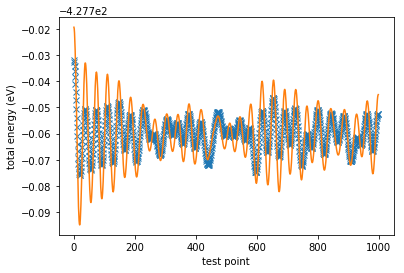

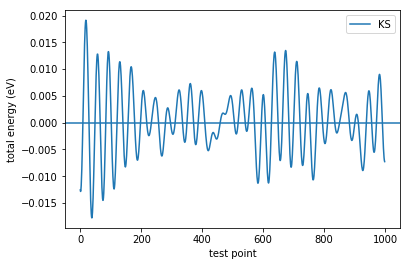


The KRR Maximum Error in kcal/mol is: 0.444925411774
The KRR MAE in kcal/mol is: 		 0.111936115954


In [24]:
import warnings
warnings.filterwarnings("ignore")

alphas = [1e0, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 0]
gammas = np.logspace(-6, 6, 48)

alphas =np.append(alphas,[0.00020235896477251638,0])
print(alphas)


gammas=np.append(gammas,0.0009102981779915227)
[kr, y_kr, errs, MAE, max_err] = fit_KS(train_pos, train_ens, \
                                            train_pos, train_ens, alphas, \
                                            gammas,cv=5)

print(kr.best_estimator_)

# plot predictions
plt.figure()
plt.plot(y_kr, 'x', label='KS')
plt.plot(test_ens, label='DFT energy')
plt.xlabel('test point')
plt.ylabel('total energy (eV)')
plt.show()

# plot erros
plt.figure()
plt.plot(y_kr - test_ens, label='KS')
plt.axhline(0)
plt.xlabel('test point')
plt.ylabel('total energy (eV)')
plt.legend()
plt.show()

print('\nThe KRR Maximum Error in kcal/mol is: '+str(max_err / kcal_conv))
print('The KRR MAE in kcal/mol is: \t\t '+str(MAE / kcal_conv))

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, ExpSineSquared
from KRR_reproduce import *

In [17]:
kernel_ = RBF(length_scale=10, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel_, n_restarts_optimizer=20, normalize_y=True)

# fit
gp.fit(train_pos, train_ens)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=10), n_restarts_optimizer=20,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [20]:
# inference
y_pred_train = gp.predict(train_pos)

# print results
print("\n=============================================")
print("MAE on training data in [kcal/mol]: \t{}".format(mean_absolute_error(train_ens, y_pred_train) / kcal_conv))


MAE on training data in [kcal/mol]: 	3.0240524333907545e-05


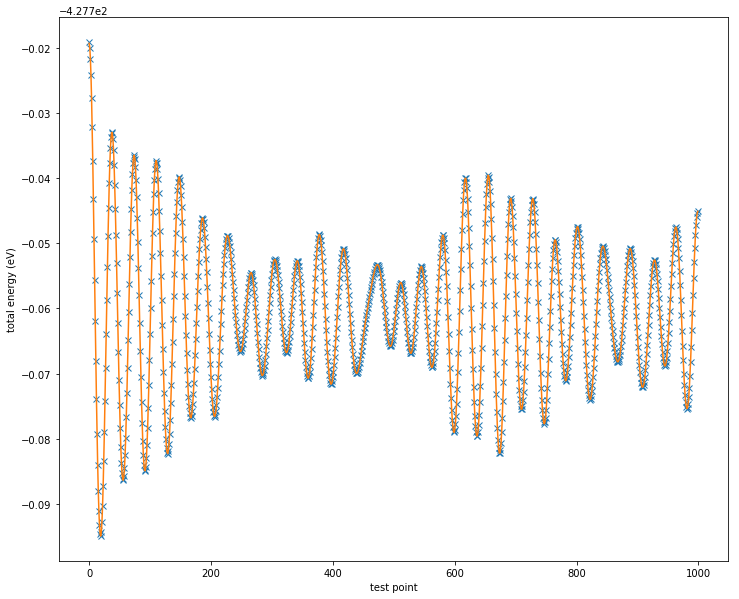

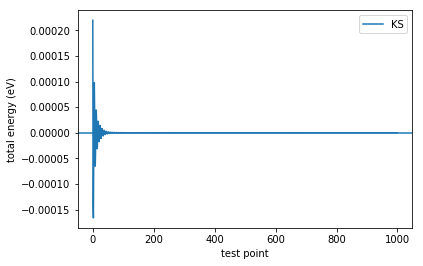

In [25]:
# plot predictions
y_kr = gp.predict(train_pos)

plt.figure(figsize = (12, 10))
plt.plot(y_kr, 'x', label='KS')
plt.plot(test_ens, label='DFT energy')
plt.xlabel('test point')
plt.ylabel('total energy (eV)')
plt.show()

# plot erros
plt.figure()
plt.plot(y_kr - test_ens, label='KS')
plt.axhline(0)
plt.xlabel('test point')
plt.ylabel('total energy (eV)')
plt.legend()
plt.show()